In [132]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [174]:
# loss matrix L_ij is the cost of guessing i when the truth is j
L = np.array([[1,1,1], [1,1,5], [1,5,1]])

# Transition matrix A_ij is the probabilty p(z_{t+1} = j|z_t = i)
# i.e. A_ij is the probability of going from i to j
K = 3
# A = np.ones((K,K)) * (1.0/3)
A = np.array([[0.3, 0.1, 0.6], [0.1, 0.4, 0.5], [0.1, 0.1, 0.8]])

# initial state probability
pi = [ 0.6, 0.3, 0.1 ]

# emission probabilities - assume Gaussian
u = [ 0, 5, 10 ]
sigma = np.ones(len(u))

In [176]:
np.argmax(np.random.multinomial(1, pi))
np.sum(A, axis=1)

array([1., 1., 1.])

array([1., 2., 2., 2., 2., 1., 1., 2., 2., 0.])

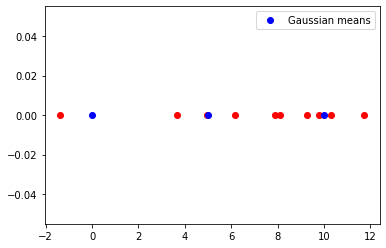

In [177]:
# generate data
T = 10
def generate_HMM(T):
    ''' TODO: loss calibrated data generation'''
    X = np.zeros(T)
    Z = np.zeros(T)
    z = np.argmax(np.random.multinomial(1, pi))
    for t in np.arange(T):
        X[t] = np.random.normal(u[z], sigma[z])
        Z[t] = z
        z = np.argmax(np.random.multinomial(1, A[z,:]))
    return X,Z
X,Z = generate_HMM(T)

plt.plot(X, np.zeros(T), 'ro')
plt.plot(u, np.zeros(len(u)), 'bo', label="Gaussian means")
plt.legend()
Z

#### Warmup: the standard Viterbi

In [179]:
# practice round: implement the regular Viterbi algorithm
def gaussian_emission_prob(x, state):
    return norm.pdf(x, u[state], sigma[state])

# initialize message
s_n_minus_1 = np.zeros(K)
s_n = np.zeros(K)
S = np.zeros((T, K, K))
P = np.zeros((T, K), dtype=int) # P for Path

t = 0
for k in np.arange(K):
    s_n_minus_1[k] = np.log(pi[k]) + np.log(gaussian_emission_prob(X[t], k))

# extend
import pdb
for t in np.arange(T-1) + 1:
    for k in np.arange(K): # z_n
        m = -np.inf # m for max
        m_l = -1
        for l in np.arange(K): # z_{n-1}
            # sum
            s = np.log(gaussian_emission_prob(X[t], k)) + np.log(A[l,k]) + s_n_minus_1[l]
            S[t, k, l] = s

            # max
            if s > m: 
                m_l = l
                m = s

        # for state k at time z_n, record the optimal z_{n-1} state and the associated p(z_1, ...., z_{n-1}=m_l, z_n=k)
        P[t,k] = m_l
        s_n[k] = m
    s_n_minus_1 = np.copy(s_n)

np.argmax(s_n)

# backtrace
viterbi_path = np.zeros(T)
viterbi_path[T-1] = np.argmax(s_n)

for t in np.arange(T-1)[::-1]:
    viterbi_path[t] = P[t+1, int(viterbi_path[t+1])]
print("*** true sequence ***")
print(Z)
print("*** viterbi sequence ***")
print(viterbi_path)
print("*** observed data ***")
print(X)

*** true sequence ***
[1. 2. 2. 2. 2. 1. 1. 2. 2. 0.]
*** viterbi sequence ***
[1. 2. 2. 2. 2. 1. 1. 2. 2. 0.]
*** observed data ***
[ 6.17884645  7.88855695  9.29019941 11.74232107 10.29441461  4.97551506
  3.67737481  8.09368493  9.78807331 -1.38754596]


#### The loss-aware Viterbi algorithm (the max-sum-product algorithm)

Suppose that we monitor the temperature at a nuclear reactor every minute. When the temperature remains above a critical tempearture, say 800 degree celcius, then we must turn the reactor off to avoid meltdown. At the same time, turning the factory off costs money, and we want to avoid turning it off when there isn't a problem.

The loss function $L(t, \hat{z})$ may be summarized in the following matrix:

| $L(t, \hat{z})$ | Off         | On   |
| --------------- |:-----------:| ----:|
| Low (< 500)     | 10          | 1    |
| Med (500, 800)  | 10          | 1    |
| High (> 800)    | 1           | 1000 |

And we will study the effect of this using the standard Viterbi and the loss calibrated Viterbi.

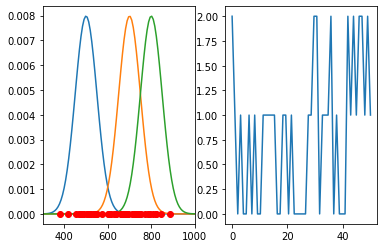

In [243]:
# st: 6:29 (why so late?)
# end: 7:10 (lost 2,3 min to espn)
# st: 7:12

# st: 5:03 :(

# st: 5:38

# Generate data:
# Suppose there are three states (low, med, high) each with a Gausisan emission.

T = 50 # time steps
K = 3

u = np.array([500, 700, 800])
sigma = np.ones(K) * 50

def gaussian_emission_prob(x, state):
    return norm.pdf(x, u[state], sigma[state])

emission_prob = gaussian_emission_prob

# plot the emission distributions
num_points = 100
xmin, xmax = 300, 1000
x = np.linspace(xmin, xmax, num_points)
plt.subplot(1,2,1)
plt.plot(x, norm.pdf(x, u[0], sigma[0]))
plt.plot(x, norm.pdf(x, u[1], sigma[1]))
plt.plot(x, norm.pdf(x, u[2], sigma[2]))
plt.xlim(xmin, xmax)

# sample points
# the transition matrix A_ij = p(i|j) i.e. columns add to 1 (so I can left multiply by the vector)
A = np.array([[0.5, 0.4, 0.1],
              [0.4, 0.4, 0.2],
              [0.2, 0.6, 0.2]]).T # note the transpose
pi = np.random.dirichlet(np.ones(K))

Z = np.zeros((T, K))
X = np.zeros(T)

Z[0] = np.random.multinomial(1, pi)
k = np.argmax(Z[0])
X[0] = np.random.normal(u[k], sigma[k])
for i in np.arange(T-1) + 1:
    Z[i] = np.random.multinomial(1, np.dot(A, Z[i-1]))
    k = np.argmax(Z[i])
    X[i] = np.random.normal(u[k], sigma[k])
plt.plot(X, np.zeros(T), 'ro')

plt.subplot(1,2,2)
plt.plot(np.linspace(0, T, T), np.argmax(Z, axis=1))

In [253]:
# Learn the parameter using the forward and backward algorithm (as a possible extension...will that change the learning?)
# Let's get to an hour, then take a break and work on real analysis, baby. I get so much done in an hour!!!

# L_ij stores the cost of decision j when the true state is i, where
# i = [ low, med, high ]
# j = [ off, on ] 
L = np.array([[10, 1], [10, 1], [1, 100]]) # since this is a multiplicative error, I think the "unit" loss should be 1.
M = 2 # decision dimension

# loss-aware Viterbi
# the element S_jk stores the message of decision k at time 1 when z_2 = j
# todo: the precise probabilisitc interpretation of the "score" is needed
S_1 = np.zeros((K, M))

# for t in np.arange(T):

# time 1 (first step)
for k in np.arange(M): # iterate over possible decisions
    for j in np.arange(K): # iterate over z_2
        for i in np.arange(K): # sum over z_1
            S_1[j,k] += np.log(L[i, k]) + np.log(emission_prob(X[1], j)) + np.log(A[i, j]) + np.log(emission_prob(X[0], i)) * np.log(pi[i])

# choose the optimum decision at time 1 for each z_2
phi_1 = np.argmin(S_1, axis=1) # optimal decision for each value of z_2
u_1 = np.min(S_1, axis=1) # for each value of z_2, stores the minimum of the message over guesses

print("after one step")
print(X[0], Z[0])
print(u_1)
print(phi_1)
print(S_1)
# The values are not probabilities (i.e. not < 0), but that's OK.

# time 2
S_2 = np.zeros((K, M))
for k in np.arange(M): # iterate over possible decisions
    for j in np.arange(K): # iterate over z_3
        for i in np.arange(K): # sum over z_2
            S_2[j,k] += np.log(L[i, k]) + np.log(emission_prob(X[2], j)) + np.log(A[i, j]) + u_1[i]

# choose the optimum decision at time 2 for each z_3
phi_2 = np.argmin(S_2, axis=1) # optimal decision for each value of z_2
u_2 = np.min(S_2, axis=1) # for each value of z_2, stores the minimum of the message over guesses

print("after two steps")
print(X[1], Z[1])
print(u_2)
print(phi_2)
print(S_2)

after one step
789.9759082883348 [0. 0. 1.]
[24.54198932 47.48689748 40.43666767]
[0 1 0]
[[24.54198932 24.54198932]
 [47.48689748 47.48689748]
 [40.43666767 40.43666767]]
after two steps
693.6454355603825 [0. 1. 0.]
[98.3825296  80.06747271 52.38726038]
[0 1 0]
[[98.3825296  98.3825296 ]
 [80.06747271 80.06747271]
 [52.38726038 52.38726038]]


The hope is that, the decision sequence obtained this way will be different from say, running Viterbi. In particular, that it is able to approximately model the posterior accurately in the regions where we care about.

The problem, though, is that Viterbi doesn't give you a probability. It's just the most likely sequence, and there's no indication of how likely it is with respect to exponentially many other possible sequece paths. It may be that the posterior terrain is really multi-modal.

But don't think too hard about that. It's just a toy modal. We can twist the scenario as we wish -- for instance, maybe what we care about is whether the plant was hot for more than a long period of time.

But there's nothing approximate happening here, so....one step at a time. Let's see where we end up now. 





In [29]:


# time 1
S_2 = np.zeros((K,K))
for k in np.arange(K): # iterate over possible guesses at time t
    for j in np.arange(K): # iterate over z_{t+1}
        for i in np.arange(K): # sum over z_t
            pass
            # S_2[k,j] += L[k, i] * emission_prob(X[2], j) * A[i, j] * 3 start here
            
# choose optimum guess z-hat at time 0 for each z at time 1
phi1 = np.argmin(S[1], axis=0)

# time 2 (last step)
S_2 = np.zeros((K,K))
for k in np.arange(K): # iterate over possible guesses at time t
    # no iteration over the next time step!
    for i in np.arange(K): # sum over z_t
        S_2[k,j] += L[k, i] * S_1[phi1[j], i]

NameError: name 'S' is not defined

In [6]:
print(X)
print(Z)
print(S_0)
print(S_1)
print(S_2)

[4.34289548 3.25522367 4.28217096]
[1. 1. 1.]


NameError: name 'S_0' is not defined

In [7]:
# return Viterbi path
back tracing easy?

Object `easy` not found.


In [54]:
np.arange(T)[1:]

array([1, 2, 3])